# Age and Sessions Played on a Minecraft Server

# todo: justify knn regression, rmse stuff

This report deals with whether age influences the amount of data generated by a player (i.e. the amount of sessions they create). 

In [25]:
library(tidyverse)
library(tidyclust)
library(tidymodels)
set.seed(12345)

These are the libraries necessary to perform our wrangling, clustering, and visualization processes. We also set the seed to `12345` to make sure this file is fully reproducible.

In [26]:
player_data <- read_csv("data/players.csv")
session_data <- read_csv("data/sessions.csv")

head(player_data)
head(session_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


We load in, and display the first six rows of each set of data we will be using. There are two sets we use:

Player data:

- Their experience (Pro, Veteran, Regular, Amateur, or Beginner)
- Whether they're subscribed to the mailing list (TRUE or FALSE)
- Their hashed email
- Hours they have spent playing (>= 0,)
- Name
- Gender (male, female, non-binary, two-spirited, agender, other, or prefer not to answer)
- Age (a whole number, or NA)
    
and session data, which keeps a record of each session, including: 

 - The player's hashed email,
 - Session start time and end time (local time) 
 - Original start and end time (Unix timestamps)

It is notable that in the session data, the end_time and original_end_time columns can contain NA values.

## Methods
First, we will clean our data, and select our necessary columns. For our player data, we will select the columns corresponding to experience and hashed email (so we can link each player to their sessions). 

We will rename the columns `Age` to `age` and `hashedEmail` to `hashed_email` for naming convention standardization. We'll also drop any players that have an N/A age, as we'll be unable to use them in our regression later on.

In [27]:
clean_player_data <- player_data |>
    rename(hashed_email = hashedEmail, age = Age) |>
    select(hashed_email, age) |> 
    drop_na(age) 



head(clean_player_data)

hashed_email,age
<chr>,<dbl>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,21
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,21
f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,17


Next, we'll clean up our session data. We'll rename $hashedEmail$ to $hashed_email$, and only select that column; we're interested in the number of sessions, not the length of sessions.

In [28]:
clean_session_data <- session_data |>
    rename(hashed_email = hashedEmail) |>
    select(hashed_email)
head(clean_session_data)

hashed_email
<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf


Recall that a hashed email is a unique identifier for each player. Since we're interested in the amount of sessions each player created, we'll use $summarise$ with $group_by$ to get the amount of sessions created by each player. 

In [29]:
sessions_by_email <- clean_session_data |>
    group_by(hashed_email) |>
    summarise(session_count = n())
head(sessions_by_email)

hashed_email,session_count
<chr>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1


Now that our data is clean, and our session data has hashed_emails linked to their session count, we can combine these two data sets into one, so we can more easily visualize it. We'll do this by matching our `hashed_email`s to each player, and adding the count column. We'll use `left_join` for this; we don't want to lose data from players that have no sessions, but it's okay if we lose data from sessions which we have no player data for (since we can't use this in our analysis). 

We'll also replace any NA counts with zero, because a count of NA means that the player had 0 sessions in our data.

Since our data is combined, we also now can remove `hashed_email`.

In [81]:
combined_session_player_data <- left_join(clean_player_data, sessions_by_email, by = "hashed_email") |>
    mutate(session_count = replace_na(session_count, 0)) |>
    select(-hashed_email)
head(combined_session_player_data)

age,session_count
<dbl>,<int>
9,27
17,3
17,1
21,1
21,1
17,0


[1]  8 50

Now that we have our data, we can start building our regression workflow. First, let's split our data into training data and test data, with a proportion of 0.75.

In [31]:
ps_split <- initial_split(combined_session_player_data, prop = 0.75, strata = session_count)
ps_training <- training(ps_split)
ps_testing <- testing(ps_split)

Next, let's make our recipe. Remember, we'll only use our training data for making our recipe and model. Our explanatory variable is age, and our response variable is session count. Since we're using K-NN regression, we need to scale and centre our predictors.

In [32]:
ps_recipe <- recipe(session_count ~ age, data = ps_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


Now we can make our regression model. Since we don't know the ideal amount of neighbours yet, we'll set `neighbors = tune()`. We'll also make our weight function rectangular, so each neighbour gets an equal "vote". We'll be using the `kknn` engine here in the regression mode.

In [33]:
ps_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

We can now put it all together in our workflow. We won't fit our data yet, since we still need to figure out what K to use.

In [55]:
ps_workflow <- workflow() |>
    add_recipe(ps_recipe) |>
    add_model(ps_spec)

Next we can make our cross-validation object; here, we'll make it 5-fold, and set our strata to be `session_count`. Again, we'll be using our training data only.

In [56]:
ps_vfold <- vfold_cv(ps_training, v = 5, strata = session_count)

Now we'll use our cross-validation object, and the workflow we made, to collect metrics on various K values. We specify the K values to use in a tibble we'll create using the tibble and seq functions. We'll test K from 1 - 30, with a step of 2. 

In [101]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

ps_results <- ps_workflow |>
    tune_grid(resamples = ps_vfold, grid = k_vals) |>
    collect_metrics() 
head(ps_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,33.378788623,5,11.472825040,Preprocessor1_Model001
1,rsq,standard,0.021902525,5,0.020293960,Preprocessor1_Model001
2,rmse,standard,36.087016450,5,9.066563826,Preprocessor1_Model002
2,rsq,standard,0.006528417,5,0.002412976,Preprocessor1_Model002
3,rmse,standard,31.858545737,5,8.440022360,Preprocessor1_Model003
3,rsq,standard,0.007497829,5,0.003764157,Preprocessor1_Model003


What we're interested in here is the root mean squared error, or `rmse`, so we'll filter for that, and select for just the `neighbors` and `mean` columns, as this is what we're interested in. We want to minimize our RMSPE, so we'll also sort from least to greatest, and pull our best K value!

In [115]:
best_k_val <- ps_results |>
    filter(.metric == "rmse") |>
    select(neighbors, mean) |>
    arrange(mean) |>
    slice(1) |>
    pull(neighbors)
best_k_val

[1] 92

The amount of neighbours with the lowest RMSPE is K = 92, so this is the value we will use. 
Now we can test our predictions using our K value on our testing data. 

To set this up, we'll need to create a new model with our new K value, but we can reuse our recipe from before. Additionally, we can now fit our workflow on our training data, since we know our K value.

In [103]:
new_ps_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_val) |>
  set_engine("kknn") |>
  set_mode("regression")
new_ps_workflow <- workflow() |>
    add_recipe(ps_recipe) |>
    add_model(new_ps_spec) |>
    fit(data = ps_training)



Now we can actually test our workflow on our testing data. We'll `predict` the session_count for our testing data, bind our prediction to the columns, and then compare them to the actual values using `metrics`. 

In [87]:
ps_metrics <- new_ps_workflow |>
  predict(ps_testing) |>
  bind_cols(ps_testing) |>
  metrics(truth = session_count, estimate = .pred)

Again, we're only interested in RMSE, so let's pull the estimate for that out.

In [88]:
test_data_rmse <- ps_metrics |> 
    filter(.metric == "rmse") |> 
    pull(.estimate)
test_data_rmse

[1] 42.73984

This means that we expect there to be an average error of 42.16 in each of our predicted session counts. This is a high error considering a good deal of our players have 0-5 sessions, so let's visualize what's happening here. The points are our actual data, and the blue line is what our model predicts for each value between 5 and 60 (our endpoints are just beyond the age range in our data).

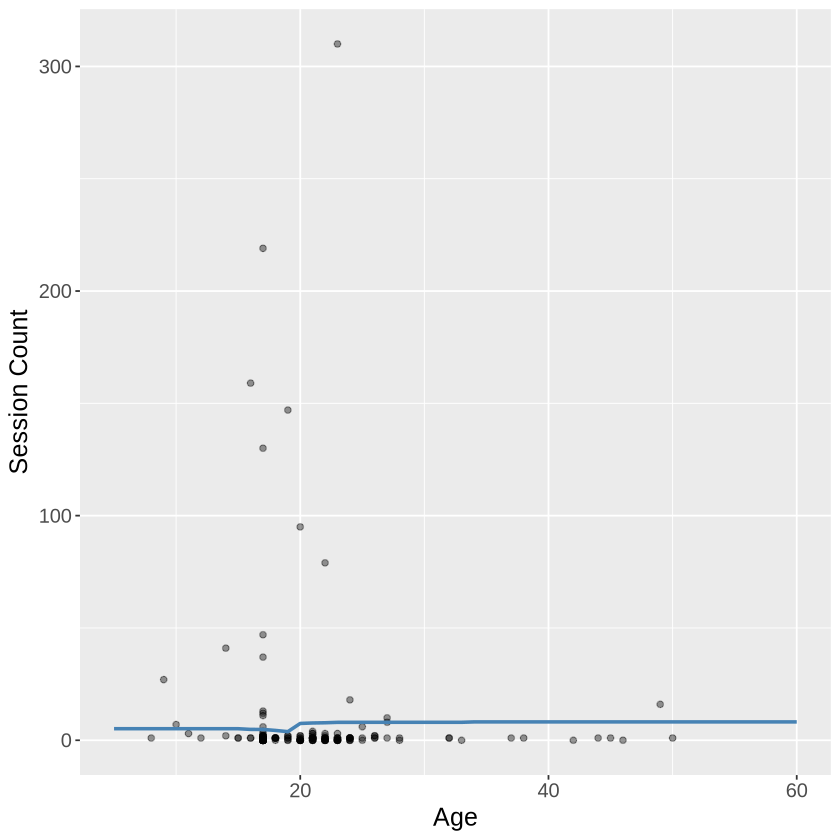

In [117]:
age_pred_grid <- tibble(
    age = seq(
        from = 5,
        to = 60,
        by = 1
    )
)

ps_preds <- new_ps_workflow |>
  predict(age_pred_grid) |>
  bind_cols(age_pred_grid)

ps_plot <- ggplot(combined_session_player_data, aes(x = age, y = session_count)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ps_preds,
            mapping = aes(x = age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Age") +
  ylab("Session Count") +
  theme(text = element_text(size = 15)) 
ps_plot

It looks like we have some pretty significant outliers here that makes it difficult for us to see our model performs. Let's zoom in, and only look at our line when session count is between 0 and 20 (where most of our data falls).

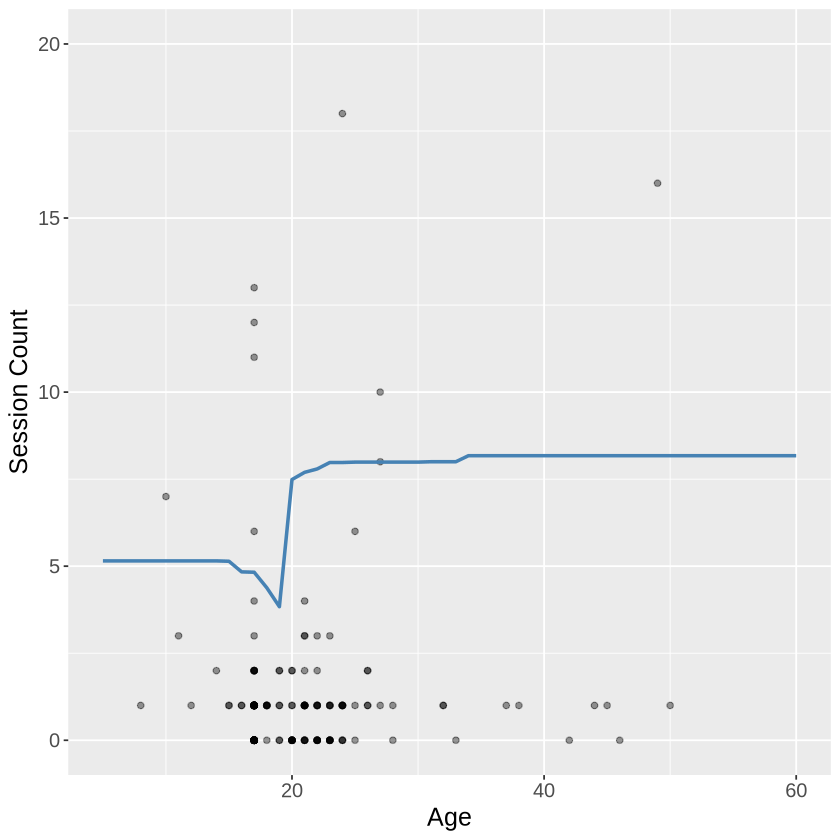

In [118]:
zoomed_in_plot <- ps_plot + coord_cartesian(ylim=c(0, 20))
zoomed_in_plot

As we would expect from our high error, our model doesn't perform very well. A good question is: why?

The answer is that it doesn't appear that the age of the player has any correlation with the amount of sessions they created. Our model can't realistically be improved very much, since there isn't any apparent relationship between our two variables for the vast majority of data points. It is interesting to note that the most significant outliers are within the range of 10-30, but this is likely due to the fact most of our data points are for those within those age ranges.

To support this visually, we can go back and plot our K vs error, we see that the RMSE isn't very good, no matter what K value we choose.

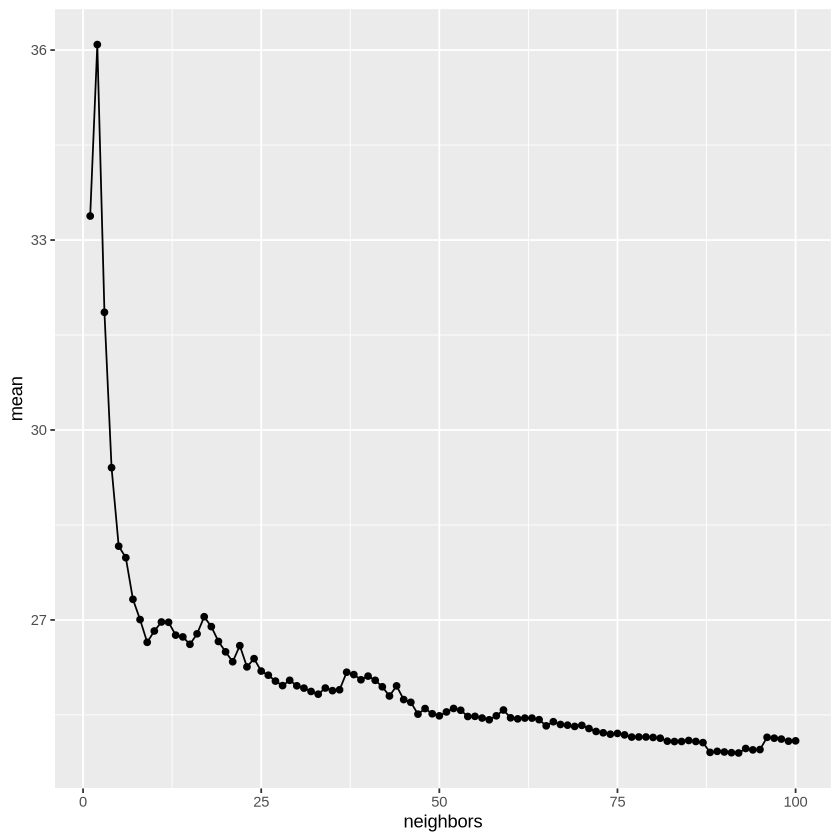

In [116]:
k_vs_mean <- ps_results |>
    filter(.metric == "rmse") |>
    select(neighbors, mean)

k_vs_mean_plot <- k_vs_mean |> 
    ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line()
k_vs_mean_plot

This means our model can't be improved very much. It's doing the best it can (or at least, very close to it). We can determine from our analysis that age and sessions created have no correlation. This isn't what I expected to find. I believed that there would be  a negative correlation between sessions created and age, as older adults tend to have more responsiblities than, say, a fifteen year old. The lack of correlatio means that the owners of this Minecraft server shouldn't look to target specific age groups if they want more data; all ages of players contribute roughly the same amount of sessions, with a few outliers.